In [1]:
import rebound
import reboundx
from celmech import Andoyer
import numpy as np
import sys
import time
%matplotlib inline
import matplotlib.pyplot as plt

from rundampresonant import damp

In [20]:
def damp(integrator, tmax, taue, scheme="", dtfactor=0.05, j=3, k=1):
    avars = Andoyer.from_elements(j=j, k=k, Zstar=0.1, libfac=0.2, m1=1.e-4, m2=1.e-12)
    sim = avars.to_Simulation()

    sim.integrator=integrator
    if integrator=="whfast":
        sim.dt = dtfactor*sim.particles[1].P

    ps = sim.particles
    P = ps[1].P
    tmax *= P
    rebx = reboundx.Extras(sim)
    mod = rebx.add("modify_orbits_forces")
    
    if scheme:
        rebx.integrator=scheme
        mod.operator_order = 1
        mod.force_as_operator = 1

    print(mod.force_as_operator)
    Nout = 
    filename = 'data/'+integrator+scheme+"taue{0:2e}.bin".format(taue)
    sim.automateSimulationArchive(filename,interval=tmax/Nout,deletefile=True)

    print(sim.particles[2].P)
    times = np.linspace(0, tmax, Nout)
    for i, time in enumerate(times):
        for p in ps[1:]:
            p.params['tau_e'] = -taue*ps[1].P
        ps[1].params['tau_a'] = taue*ps[1].P*100
        sim.integrate(time, exact_finish_time=0)

In [27]:
from subprocess import call
integrator = 'whfast'
taue=1.e4
scheme="rk4"
Nout = 1000
tmax=2.

In [22]:
damp(integrator='whfast', tmax=tmax, taue=taue, scheme=scheme)
damp(integrator='ias15', tmax=tmax, taue=taue)

1
9.452612228378435


/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


0
9.452612228378435


data/whfastrk4taue1.000000e+04.bin
data/ias15taue1.000000e+04.bin
CPU times: user 1.36 s, sys: 160 ms, total: 1.52 s
Wall time: 1.51 s


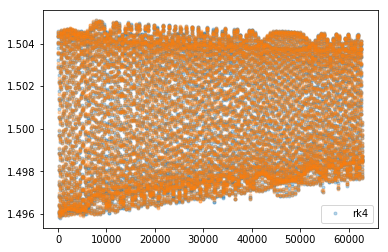

In [28]:
%%time
fig, ax = plt.subplots()

Pratio, times, e1, e2, a1 = np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1))
E = np.zeros((2, Nout+1))

for k, (integrator, scheme, taue) in enumerate([('whfast', 'rk4', taue), ('ias15', '', taue)]):
    filename = 'data/'+integrator+scheme+"taue{0:.6e}.bin".format(taue)
    print(filename)
    sa = rebound.SimulationArchive(filename)
    for i, sim in enumerate(sa):
        Pratio[k, i] = sim.particles[2].P/sim.particles[1].P
        times[k, i] = sim.t
        e1[k, i] = sim.particles[1].e
        e2[k, i] = sim.particles[2].e
        a1[k, i] = sim.particles[1].a
        E[k, i] = sim.calculate_energy()
    ax.plot(times[k], Pratio[k], '.', alpha=0.3, label=scheme)
ax.legend()

In [11]:
tmax=1.e4
if scheme:
    call('python rundampresonant.py {0} {1} {2} {3} &'.format(integrator, tmax, taue, scheme), shell=True)
else:
    call('python rundampresonant.py {0} {1} {2} &'.format(integrator, tmax, taue), shell=True)

In [14]:
taues = [1.e4]
integrators = ['whfast']
schemes = ['rk4']
Nout = 10000

***10000.0***
data/whfastrk4taue1.000000e+04.bin


/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


NameError: name 'a1ref' is not defined

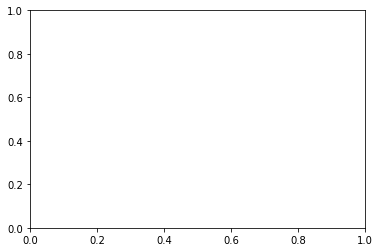

In [15]:
%%time
fig, ax = plt.subplots()

for taue in taues:
    print("***{0}***".format(taue))

    for integrator, scheme in zip(integrators, schemes):
        filename = 'data/'+integrator+scheme+"taue{0:2e}.bin".format(taue)
        print(filename)
        sa = rebound.SimulationArchive(filename)
        Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
        for i, sim in enumerate(sa):
            Pratio[i] = sim.particles[2].P/sim.particles[1].P
            times[i] = sim.t
            e1[i] = sim.particles[1].e
            e2[i] = sim.particles[2].e
            a1[i] = sim.particles[1].a
        if integrator == 'ias15':
            a1ref = np.median(a1[9000:])
            e1ref = np.median(e1[9000:])
            e2ref = np.median(e2[9000:])
            Pratioref = np.median(Pratio[9000:])
        else:
            print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
        ax.plot(times, Pratio, '.')

In [16]:
from subprocess import call
integrators = ['ias15', 'whfast']#, 'whfast']
schemes = ['euler', 'rk2', 'rk4']#, 'operator']
taues = [1.e3, 1.e3*(1.+1.e-5)]#, 1.e5, 1.e7, 1.e9]
tmax = 1.e3

In [17]:
from itertools import combinations
list(zip(['whfast']*len(schemes), schemes))

[('whfast', 'euler'), ('whfast', 'rk2'), ('whfast', 'rk4')]

In [18]:
for taue in taues:
    for integrator, scheme in [('ias15', '')] + list(zip(['whfast']*len(schemes), schemes)):
        print(integrator, scheme, taue)
        if scheme:
            call('python rundampresonant.py {0} {1} {2} {3} &'.format(integrator, tmax, taue, scheme), shell=True)
        else:
            call('python rundampresonant.py {0} {1} {2} &'.format(integrator, tmax, taue), shell=True)

ias15  1000.0
whfast euler 1000.0
whfast rk2 1000.0
whfast rk4 1000.0
ias15  1000.0100000000001
whfast euler 1000.0100000000001
whfast rk2 1000.0100000000001
whfast rk4 1000.0100000000001


data/whfasteulertaue1.000000e+03.bin


/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


data/whfastrk4taue1.000000e+03.bin
CPU times: user 1.31 s, sys: 232 ms, total: 1.55 s
Wall time: 1.55 s


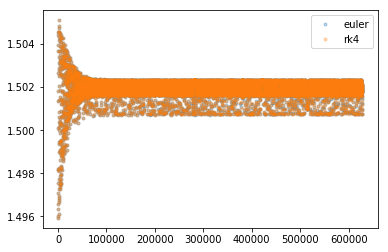

In [25]:
%%time
fig, ax = plt.subplots()

#taue = taues[0]
Pratio, times, e1, e2, a1 = np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1))
E = np.zeros((2, Nout+1))

for k, (integrator, scheme, taue) in enumerate([('whfast', 'euler', 1.e3), ('whfast', 'rk4', 1.e3)]):
    filename = 'data/'+integrator+scheme+"taue{0:.6e}.bin".format(taue)
    print(filename)
    sa = rebound.SimulationArchive(filename)
    for i, sim in enumerate(sa):
        Pratio[k, i] = sim.particles[2].P/sim.particles[1].P
        times[k, i] = sim.t
        e1[k, i] = sim.particles[1].e
        e2[k, i] = sim.particles[2].e
        a1[k, i] = sim.particles[1].a
        E[k, i] = sim.calculate_energy()
    ax.plot(times[k], Pratio[k], '.', alpha=0.3, label=scheme)
ax.legend()

data/whfasteulertaue1.000000e+03.bin


/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


data/whfastrk4taue1.000000e+03.bin
CPU times: user 1.31 s, sys: 232 ms, total: 1.55 s
Wall time: 1.55 s


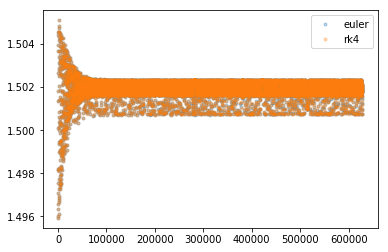

In [25]:
%%time
fig, ax = plt.subplots()

#taue = taues[0]
Pratio, times, e1, e2, a1 = np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1))
E = np.zeros((2, Nout+1))

for k, (integrator, scheme, taue) in enumerate([('whfast', 'euler', 1.e3), ('whfast', 'rk4', 1.e3)]):
    filename = 'data/'+integrator+scheme+"taue{0:.6e}.bin".format(taue)
    print(filename)
    sa = rebound.SimulationArchive(filename)
    for i, sim in enumerate(sa):
        Pratio[k, i] = sim.particles[2].P/sim.particles[1].P
        times[k, i] = sim.t
        e1[k, i] = sim.particles[1].e
        e2[k, i] = sim.particles[2].e
        a1[k, i] = sim.particles[1].a
        E[k, i] = sim.calculate_energy()
    ax.plot(times[k], Pratio[k], '.', alpha=0.3, label=scheme)
ax.legend()

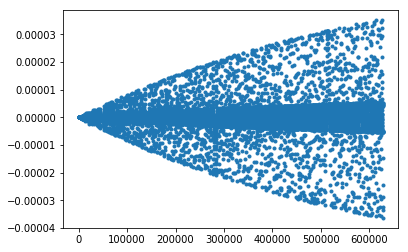

In [26]:
fig, ax = plt.subplots()
ax.plot(times[0], Pratio[1]-Pratio[0], '.')

data/whfastrk4taue1.000000e+03.bin


/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


data/whfastrk4taue1.000010e+03.bin
CPU times: user 1.3 s, sys: 214 ms, total: 1.52 s
Wall time: 1.52 s


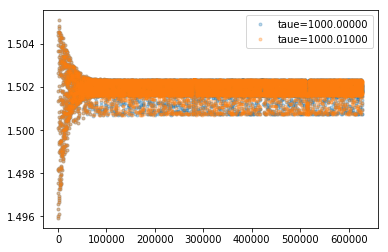

In [18]:
%%time
fig, ax = plt.subplots()

#taue = taues[0]
Pratio, times, e1, e2, a1 = np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1)), np.zeros((2, Nout+1))
E = np.zeros((2, Nout+1))

for k, (integrator, scheme, taue) in enumerate([('whfast', 'rk4', 1.e3), ('whfast', 'rk4', 1.e3*(1.+1.e-5))]):
    filename = 'data/'+integrator+scheme+"taue{0:.6e}.bin".format(taue)
    print(filename)
    sa = rebound.SimulationArchive(filename)
    for i, sim in enumerate(sa):
        Pratio[k, i] = sim.particles[2].P/sim.particles[1].P
        times[k, i] = sim.t
        e1[k, i] = sim.particles[1].e
        e2[k, i] = sim.particles[2].e
        a1[k, i] = sim.particles[1].a
        E[k, i] = sim.calculate_energy()
    ax.plot(times[k], Pratio[k], '.', alpha=0.3, label='taue={:.5f}'.format(taue))
ax.legend()

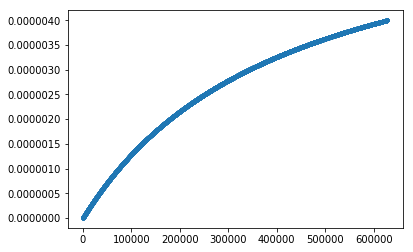

In [19]:
fig, ax = plt.subplots()
ax.plot(times[0], (E[1]-E[0])/E[0], '.')

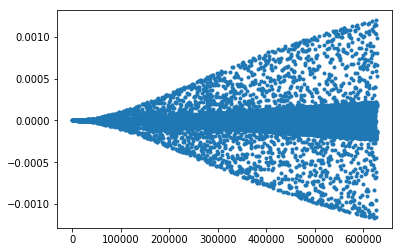

In [20]:
fig, ax = plt.subplots()
ax.plot(times[0], Pratio[1]-Pratio[0], '.')

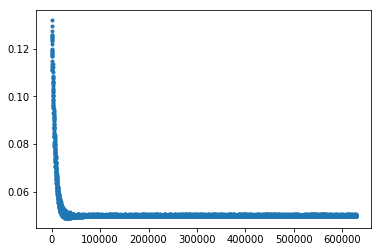

In [73]:
fig, ax = plt.subplots()
ax.plot(times[0], e2[1], '.')

data/whfastrk2taue1.000000e+03.bin
('data/whfastrk2taue1.000000e+03.bin', -3.5309341561682809e-08, 0.0031615020584403334, -2.3363614783135515e-05, -6.9005487342557663e-07)
data/whfastrk4taue1.000000e+03.bin
('data/whfastrk4taue1.000000e+03.bin', -3.5309192228441845e-08, 0.0031615000133412264, -2.336413506642873e-05, -6.9006290634298268e-07)
CPU times: user 2.65 s, sys: 135 ms, total: 2.78 s
Wall time: 2.78 s


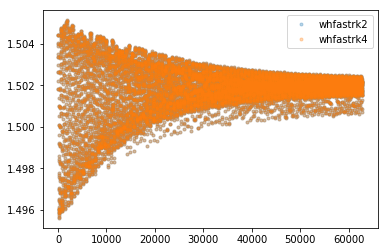

In [30]:
%%time
fig, ax = plt.subplots()

taue = taues[0]

for integrator, scheme in [('whfast', 'rk2'), ('whfast', 'rk4')]:
    filename = 'data/'+integrator+scheme+"taue{0:.6e}.bin".format(taue)
    print(filename)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    if integrator == 'ias15':
        a1ref = np.median(a1[9000:])
        e1ref = np.median(e1[9000:])
        e2ref = np.median(e2[9000:])
        Pratioref = np.median(Pratio[9000:])
    else:
        print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, Pratio, '.', alpha=0.3, label=integrator+scheme)
ax.legend()

***1000.0***
data/ias15taue1.000000e+03.bin
data/whfasttaue1.000000e+03.bin
('data/whfasttaue1.000000e+03.bin', -4.5026417963636323e-08, 0.0031588811890768988, -3.9093873553534704e-06, 8.5779528345312198e-07)
data/whfastrk2taue1.000000e+03.bin
('data/whfastrk2taue1.000000e+03.bin', -3.5309341561682809e-08, 0.0031615020584403334, -2.3363614783135515e-05, -6.9005487342557663e-07)
data/whfastrk4taue1.000000e+03.bin
('data/whfastrk4taue1.000000e+03.bin', -3.5309192228441845e-08, 0.0031615000133412264, -2.336413506642873e-05, -6.9006290634298268e-07)
CPU times: user 5.39 s, sys: 329 ms, total: 5.72 s
Wall time: 5.71 s


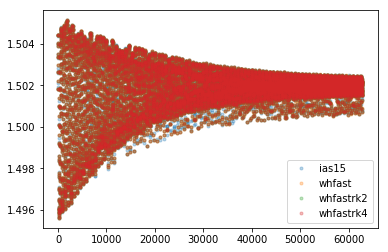

In [29]:
%%time
fig, ax = plt.subplots()

for taue in taues:
    print("***{0}***".format(taue))

    for integrator, scheme in [('ias15', '')] + list(zip(['whfast']*len(schemes), schemes)):
        filename = 'data/'+integrator+scheme+"taue{0:.6e}.bin".format(taue)
        print(filename)
        sa = rebound.SimulationArchive(filename)
        Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
        for i, sim in enumerate(sa):
            Pratio[i] = sim.particles[2].P/sim.particles[1].P
            times[i] = sim.t
            e1[i] = sim.particles[1].e
            e2[i] = sim.particles[2].e
            a1[i] = sim.particles[1].a
        if integrator == 'ias15':
            a1ref = np.median(a1[9000:])
            e1ref = np.median(e1[9000:])
            e2ref = np.median(e2[9000:])
            Pratioref = np.median(Pratio[9000:])
        else:
            print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
        ax.plot(times, Pratio, '.', alpha=0.3, label=integrator+scheme)
ax.legend()

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


whfasttaue1.000000e+09.bin -6.4667833944e-10 0.00023278695414 4.7446170816e-05 -7.21694520608e-06
whfastoperatortaue1.000000e+09.bin -7.8503073743e-10 -4.8221405381e-05 5.97605611045e-05 -6.40449196624e-06


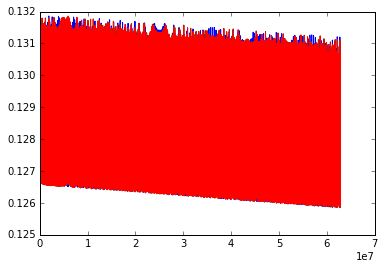

In [62]:
fig, ax = plt.subplots()

taue=1.e9
for integrator, scheme in zip(integrators, schemes):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    if integrator == 'ias15':
        a1ref = np.median(a1[9000:])
        e1ref = np.median(e1[9000:])
        e2ref = np.median(e2[9000:])
        Pratioref = np.median(Pratio[9000:])
    else:
        print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, e2)

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


whfasttaue1.000000e+03.bin -2.42067872355e-07 1.24886586376e-06 -2.99394129279e-08 -2.68051010306e-06
whfastoperatortaue1.000000e+03.bin -2.39177878991e-07 -3.1479601274e-06 5.17308529009e-05 -3.00699286112e-06


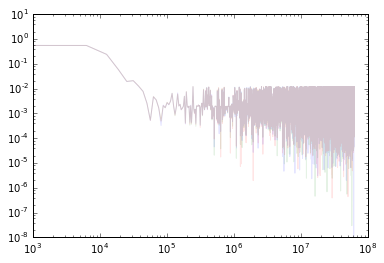

In [50]:
fig, ax = plt.subplots()

taue=1.e3
for integrator, scheme in zip(integrators, schemes):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    if integrator == 'ias15':
        a1ref = np.median(a1[9000:])
        e1ref = np.median(e1[9000:])
        e2ref = np.median(e2[9000:])
        Pratioref = np.median(Pratio[9000:])
    else:
        print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, np.abs((e2-e2ref)/e2ref), alpha=0.1)
    
ax.set_xscale('log')
ax.set_yscale('log')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


whfasttaue1.000000e+07.bin 8.96829367468e-11 -0.0232213545064 0.00412972661406 0.00073799434732
whfastoperatortaue1.000000e+07.bin 8.78500107677e-11 -0.0100043247277 0.00416946985137 0.000699482601527


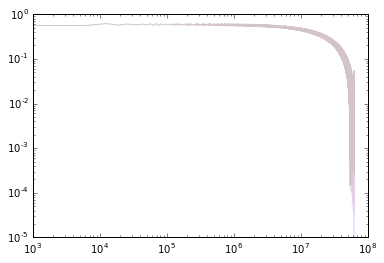

In [51]:
fig, ax = plt.subplots()

taue=1.e7
for integrator, scheme in zip(integrators, schemes):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    if integrator == 'ias15':
        a1ref = np.median(a1[9000:])
        e1ref = np.median(e1[9000:])
        e2ref = np.median(e2[9000:])
        Pratioref = np.median(Pratio[9000:])
    else:
        print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, np.abs((e2-e2ref)/e2ref), alpha=0.1)
    
ax.set_xscale('log')
ax.set_yscale('log')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


whfasttaue1.000000e+05.bin 1.47997358975e-09 0.0001380079354 -5.75673500759e-05 6.7521611984e-06
whfastoperatortaue1.000000e+05.bin 1.78401579632e-09 0.00156151408781 0.000120753341332 5.62117248697e-06


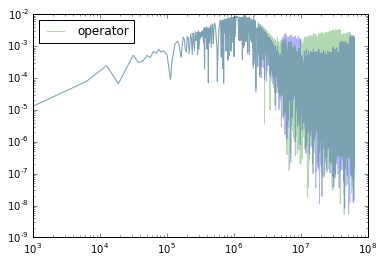

In [58]:
fig, ax = plt.subplots()

taue=1.e5
integrator='ias15'
scheme=''
filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
sa = rebound.SimulationArchive(filename)
PratioIAS15, timesIAS15, e1IAS15, e2IAS15, a1IAS15 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
for i, sim in enumerate(sa):
    PratioIAS15[i] = sim.particles[2].P/sim.particles[1].P
    timesIAS15[i] = sim.t
    e1IAS15[i] = sim.particles[1].e
    e2IAS15[i] = sim.particles[2].e
    a1IAS15[i] = sim.particles[1].a
a1ref = np.median(a1IAS15[9000:])
e1ref = np.median(e1IAS15[9000:])
e2ref = np.median(e2IAS15[9000:])
Pratioref = np.median(PratioIAS15[9000:])

for integrator, scheme in (('whfast', ''), ('whfast', 'operator')):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, np.abs((e2-e2IAS15)/e2IAS15), alpha=0.3, label=scheme)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


whfasttaue1.000000e+03.bin -2.42067872355e-07 1.24886586376e-06 -2.99394129279e-08 -2.68051010306e-06
whfastoperatortaue1.000000e+03.bin -2.39177878991e-07 -3.1479601274e-06 5.17308529009e-05 -3.00699286112e-06


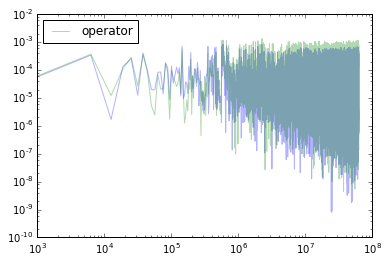

In [59]:
fig, ax = plt.subplots()

taue=1.e3
integrator='ias15'
scheme=''
filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
sa = rebound.SimulationArchive(filename)
PratioIAS15, timesIAS15, e1IAS15, e2IAS15, a1IAS15 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
for i, sim in enumerate(sa):
    PratioIAS15[i] = sim.particles[2].P/sim.particles[1].P
    timesIAS15[i] = sim.t
    e1IAS15[i] = sim.particles[1].e
    e2IAS15[i] = sim.particles[2].e
    a1IAS15[i] = sim.particles[1].a
a1ref = np.median(a1IAS15[9000:])
e1ref = np.median(e1IAS15[9000:])
e2ref = np.median(e2IAS15[9000:])
Pratioref = np.median(PratioIAS15[9000:])

for integrator, scheme in (('whfast', ''), ('whfast', 'operator')):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, np.abs((e2-e2IAS15)/e2IAS15), alpha=0.3, label=scheme)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


whfasttaue1.000000e+07.bin 8.96829367468e-11 -0.0232213545064 0.00412972661406 0.00073799434732
whfastoperatortaue1.000000e+07.bin 8.78500107677e-11 -0.0100043247277 0.00416946985137 0.000699482601527


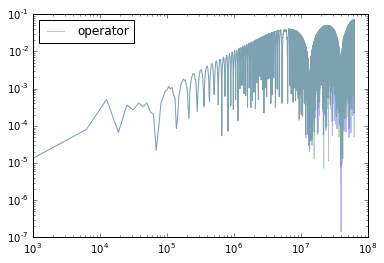

In [60]:
fig, ax = plt.subplots()

taue=1.e7
integrator='ias15'
scheme=''
filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
sa = rebound.SimulationArchive(filename)
PratioIAS15, timesIAS15, e1IAS15, e2IAS15, a1IAS15 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
for i, sim in enumerate(sa):
    PratioIAS15[i] = sim.particles[2].P/sim.particles[1].P
    timesIAS15[i] = sim.t
    e1IAS15[i] = sim.particles[1].e
    e2IAS15[i] = sim.particles[2].e
    a1IAS15[i] = sim.particles[1].a
a1ref = np.median(a1IAS15[9000:])
e1ref = np.median(e1IAS15[9000:])
e2ref = np.median(e2IAS15[9000:])
Pratioref = np.median(PratioIAS15[9000:])

for integrator, scheme in (('whfast', ''), ('whfast', 'operator')):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, np.abs((e2-e2IAS15)/e2IAS15), alpha=0.3, label=scheme)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


whfasttaue1.000000e+09.bin -6.4667833944e-10 0.00023278695414 4.7446170816e-05 -7.21694520608e-06
whfastoperatortaue1.000000e+09.bin -7.8503073743e-10 -4.8221405381e-05 5.97605611045e-05 -6.40449196624e-06


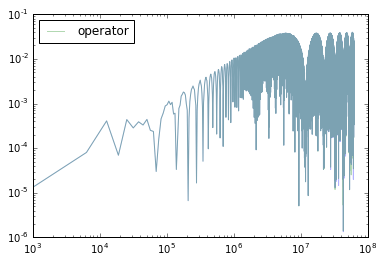

In [61]:
fig, ax = plt.subplots()

taue=1.e9
integrator='ias15'
scheme=''
filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
sa = rebound.SimulationArchive(filename)
PratioIAS15, timesIAS15, e1IAS15, e2IAS15, a1IAS15 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
for i, sim in enumerate(sa):
    PratioIAS15[i] = sim.particles[2].P/sim.particles[1].P
    timesIAS15[i] = sim.t
    e1IAS15[i] = sim.particles[1].e
    e2IAS15[i] = sim.particles[2].e
    a1IAS15[i] = sim.particles[1].a
a1ref = np.median(a1IAS15[9000:])
e1ref = np.median(e1IAS15[9000:])
e2ref = np.median(e2IAS15[9000:])
Pratioref = np.median(PratioIAS15[9000:])

for integrator, scheme in (('whfast', ''), ('whfast', 'operator')):
    filename = integrator+scheme+"taue{0:.6e}.bin".format(taue)
    sa = rebound.SimulationArchive(filename)
    Pratio, times, e1, e2, a1 = np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1), np.zeros(Nout+1)
    for i, sim in enumerate(sa):
        Pratio[i] = sim.particles[2].P/sim.particles[1].P
        times[i] = sim.t
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        a1[i] = sim.particles[1].a
    print(filename, np.sign(np.median(a1[9000:])-a1ref)*np.abs((np.median(a1[9000:])-a1ref)/a1ref), np.sign(np.median(e1[9000:])-e1ref)*np.abs((np.median(e1[9000:])-e1ref)/e1ref), np.sign(np.median(e2[9000:])-e2ref)*np.abs((np.median(e2[9000:])-e2ref)/e2ref), np.sign(np.median(Pratio[9000:])-Pratioref)*np.abs((np.median(Pratio[9000:])-Pratioref)/Pratioref))
    ax.plot(times, np.abs((e2-e2IAS15)/e2IAS15), alpha=0.3, label=scheme)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left')

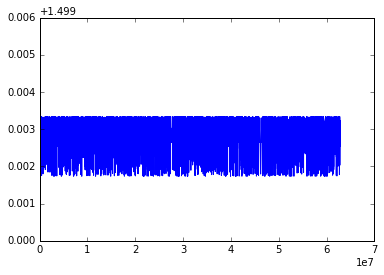

In [33]:
fig, ax = plt.subplots()
ax.plot(times, Pratio)

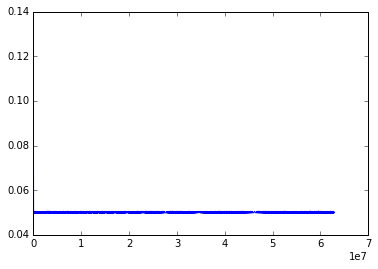

In [34]:
fig, ax = plt.subplots()
ax.plot(times, e2)